# Shallow Water

## Model Reconstruction

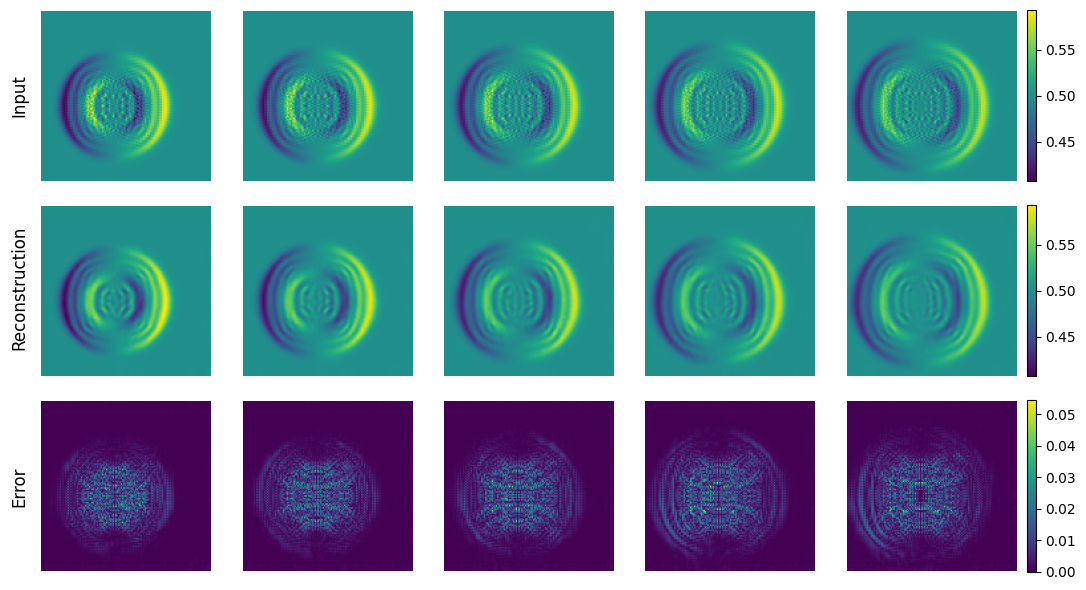

In [21]:
from data.dataset import ShallowWaterDataset
from models.timae.pl_model import LitTiMAE
import matplotlib.pyplot as plt
import torch

dataset = ShallowWaterDataset(dilation=3)
model = LitTiMAE.load_from_checkpoint('logs/timae/dilation3/lightning_logs/version_0/checkpoints/epoch=34-step=82950.ckpt', map_location='cpu', dataset=dataset)

x, y, mask, _ = dataset[10]
pred = model.model(x.unsqueeze(0), mask.unsqueeze(0))[0].squeeze(0).detach()

fig, axs = plt.subplots(3, 6, figsize=(11, 6), gridspec_kw={'width_ratios': [0, 1, 1, 1, 1, 1.25]})

axs[0, 0].text(x=0, y=0.4, s='Input', fontsize='large', rotation='vertical')
axs[1, 0].text(x=0, y=0.18, s='Reconstruction', fontsize='large', rotation='vertical')
axs[2, 0].text(x=0, y=0.4, s='Error', fontsize='large', rotation='vertical')

images = y[:, 1]
reconstructions = pred[10:, 1]
diffs = torch.abs(images - reconstructions)
i_vmin, i_vmax = torch.cat([images, reconstructions]).min(), torch.cat([images, reconstructions]).max()
for i in range(5):
    im1 = axs[0, i+1].imshow(images[i], vmin=i_vmin, vmax=i_vmax)
    im2 = axs[1, i+1].imshow(reconstructions[i], vmin=i_vmin, vmax=i_vmax)
    im3 = axs[2, i+1].imshow(diffs[i], vmin=diffs.min(), vmax=diffs.max())

fig.colorbar(im1, ax=axs[0, i+1], shrink=1, format='%.2f')
fig.colorbar(im2, ax=axs[1, i+1], shrink=1, format='%.2f')
fig.colorbar(im3, ax=axs[2, i+1], shrink=1, format='%.2f')

for i in range(3):
    for j in range(6):
        axs[i, j].axis('off')

plt.tight_layout()
# plt.savefig('sw_reconstruction.pdf', bbox_inches='tight', dpi=100)

## CAE Evaluation

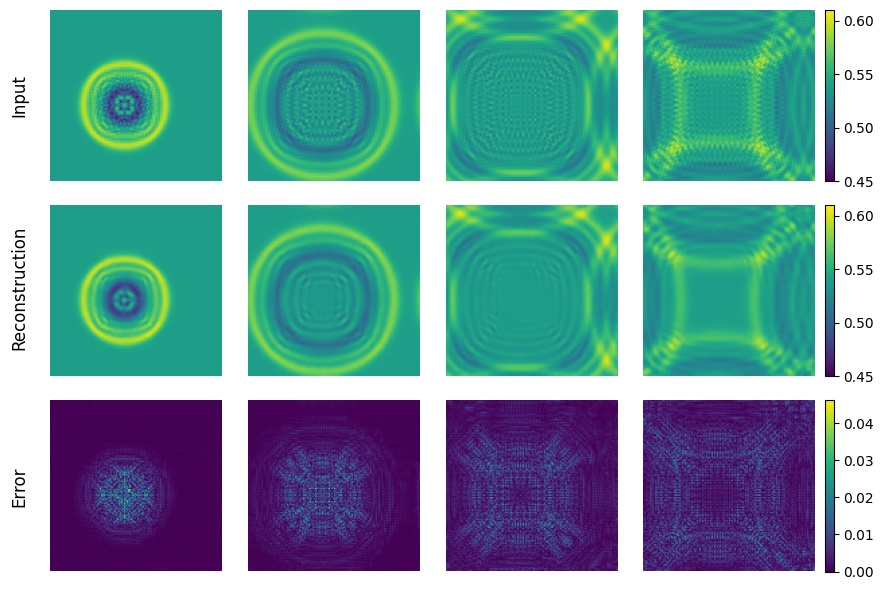

In [1]:
from data.dataset import ShallowWaterDataset
from models.autoencoder.pl_model import LitAutoEncoder
import matplotlib.pyplot as plt
import torch

dataset = ShallowWaterDataset(1, 0, 0, 1)
model = LitAutoEncoder.load_from_checkpoint('logs/autoencoder/shallow_water.ckpt', map_location='cpu', dataset=dataset)

ids = [30, 60, 90, 120]

fig, axs = plt.subplots(3, 5, figsize=(9, 6), gridspec_kw={'width_ratios': [0.1, 1, 1, 1, 1.21]})

axs[0, 0].text(x=0, y=0.4, s='Input', fontsize='large', rotation='vertical')
axs[1, 0].text(x=0, y=0.18, s='Reconstruction', fontsize='large', rotation='vertical')
axs[2, 0].text(x=0, y=0.4, s='Error', fontsize='large', rotation='vertical')
for j in range(3):
    axs[j, 0].axis('off')

for i in range(4):
    image = dataset[ids[i]][0][0]
    reconstruction = model.model(image.unsqueeze(0).unsqueeze(0))[0].squeeze().detach()
    diff = torch.abs(image - reconstruction)

    im1 = axs[0, i+1].imshow(image[0], vmin=0.45, vmax=0.61)
    im2 = axs[1, i+1].imshow(reconstruction[0], vmin=0.45, vmax=0.61)
    im3 = axs[2, i+1].imshow(diff[0], vmin=0, vmax=0.0462)

    for j in range(3):
        axs[j, i+1].axis('off')

fig.colorbar(im1, ax=axs[0, i+1], shrink=1, format='%.2f')
fig.colorbar(im2, ax=axs[1, i+1], shrink=1, format='%.2f')
fig.colorbar(im3, ax=axs[2, i+1], shrink=1, format='%.2f')

plt.tight_layout()
# plt.savefig('sw_cae_evaluation.pdf', bbox_inches='tight', dpi=100)

## Model Comparison

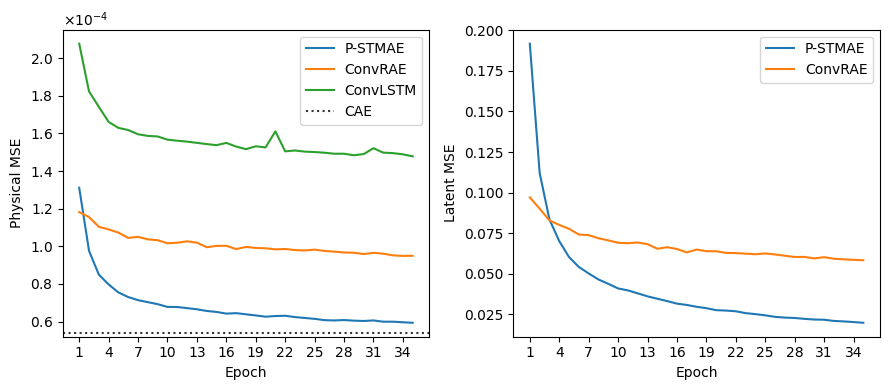

In [2]:
import os
import numpy as np
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter


# Load TensorBoard log data
all_stats = {}
for model in ['timae', 'convrae', 'convlstm']:
    stats = {
        'val/mse': {'steps': [], 'values': []},
        'val/latent_mse': {'steps': [], 'values': []},
    }
    # Load the data from multiple runs
    for ver_name in os.listdir(f"logs/{model}/dilation3/lightning_logs"):
        event_acc = event_accumulator.EventAccumulator(f"logs/{model}/dilation3/lightning_logs/{ver_name}")
        event_acc.Reload()
        for stat in stats.keys():
            if model == 'convlstm' and 'latent' in stat:
                continue
            steps = [event.step for event in event_acc.Scalars(stat)]
            values = [event.value for event in event_acc.Scalars(stat)]
            stats[stat]['steps'].append(steps)
            stats[stat]['values'].append(values)
    # convert to numpy arrays
    for stat in stats.keys():
        stats[stat]['steps'] = np.array(stats[stat]['steps'])
        stats[stat]['values'] = np.array(stats[stat]['values'])
    all_stats[model] = stats

event_acc = event_accumulator.EventAccumulator(f"logs/autoencoder/lightning_logs/prod")
event_acc.Reload()
ae_metric = lambda x: event_acc.Scalars(x)[-1].value

model_name = {'timae': 'P-STMAE', 'convrae': 'ConvRAE', 'convlstm': 'ConvLSTM'}


fig = plt.figure(figsize=(9, 4))
gs = gridspec.GridSpec(1, 2, height_ratios=[1])

ax, stat = fig.add_subplot(gs[0, 0]), 'val/mse'
max_steps = max([all_stats[model][stat]['steps'][0][-1] for model in all_stats.keys()])
for j, model in enumerate(all_stats.keys()):
    # Extract mean and std
    steps = all_stats[model][stat]['steps'][0]
    mean_values = np.mean(all_stats[model][stat]['values'], axis=0)
    std_values = np.std(all_stats[model][stat]['values'], axis=0)

    # Visualize the data
    ax.plot(steps, mean_values, label=model_name[model])
ax.axhline(ae_metric(stat), linestyle=':', color='black', alpha=0.8,  label='CAE')
ax.set_xticks(steps[::3], ((steps + 1) // 2370)[::3])
ax.set_xlabel('Epoch')
ax.set_ylabel('Physical MSE')
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-4, 4))
ax.yaxis.set_major_formatter(formatter)
ax.legend()

ax, stat = fig.add_subplot(gs[0, 1]), 'val/latent_mse'
max_steps = max([all_stats[model][stat]['steps'][0][-1] for model in ['timae', 'convrae']])
for j, model in enumerate(['timae', 'convrae']):
    # Extract mean and std
    steps = all_stats[model][stat]['steps'][0]
    mean_values = np.mean(all_stats[model][stat]['values'], axis=0)
    std_values = np.std(all_stats[model][stat]['values'], axis=0)

    # Visualize the data
    ax.plot(steps, mean_values, label=model_name[model])
ax.set_xticks(steps[::3], ((steps + 1) // 2370)[::3])
ax.set_xlabel('Epoch')
ax.set_ylabel('Latent MSE')
ax.legend()

plt.tight_layout()
# plt.savefig('sw_comparison.pdf', bbox_inches='tight', dpi=100)

## Missing Ratio Analysis

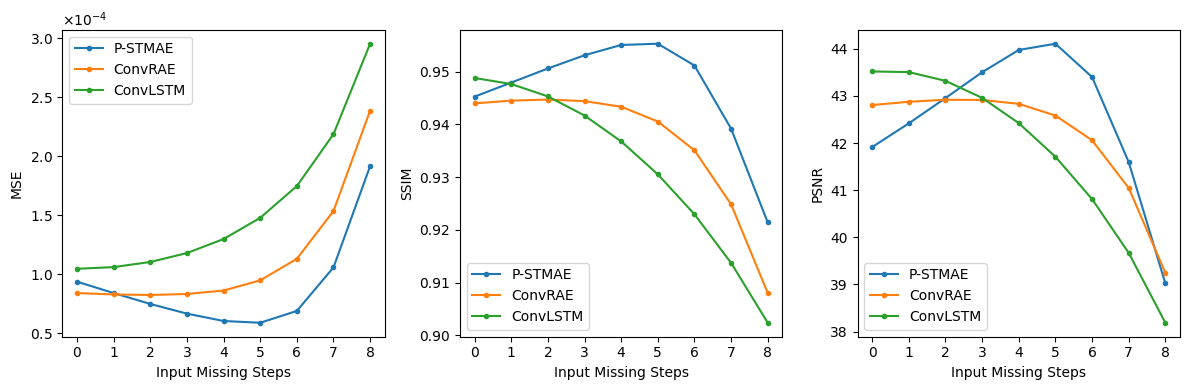

In [3]:
import os
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter


mask_nums = [0, 1, 2, 3, 4, 5, 6, 7, 8]

# Load TensorBoard log data
all_stats = {}
for model in ['timae', 'convrae', 'convlstm']:
    stats = {
        'test/mse': [],
        'test/ssim': [],
        'test/psnr': [],
    }
    # Load the data from multiple runs
    for mask_num in mask_nums:
        for ver_name in os.listdir(f"logs/{model}/mask{mask_num}/lightning_logs"):
            event_acc = event_accumulator.EventAccumulator(f"logs/{model}/mask{mask_num}/lightning_logs/{ver_name}")
            event_acc.Reload()
            for stat in stats.keys():
                stats[stat].append(event_acc.Scalars(stat)[-1].value)
    all_stats[model] = stats

model_name = {'timae': 'P-STMAE', 'convrae': 'ConvRAE', 'convlstm': 'ConvLSTM'}


fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3, height_ratios=[1])

ax, stat = fig.add_subplot(gs[0, 0]), 'test/mse'
for j, model in enumerate(all_stats.keys()):
    ax.plot(mask_nums, all_stats[model][stat], label=model_name[model], marker='.')
ax.set_xticks(mask_nums)
ax.set_xlabel('Input Missing Steps')
ax.set_ylabel('MSE')
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-4, 4))
ax.yaxis.set_major_formatter(formatter)
ax.legend()

ax, stat = fig.add_subplot(gs[0, 1]), 'test/ssim'
for j, model in enumerate(all_stats.keys()):
    ax.plot(mask_nums, all_stats[model][stat], label=model_name[model], marker='.')
ax.set_xticks(mask_nums)
ax.set_xlabel('Input Missing Steps')
ax.set_ylabel('SSIM')
ax.legend()

ax, stat = fig.add_subplot(gs[0, 2]), 'test/psnr'
for j, model in enumerate(all_stats.keys()):
    ax.plot(mask_nums, all_stats[model][stat], label=model_name[model], marker='.')
ax.set_xticks(mask_nums)
ax.set_xlabel('Input Missing Steps')
ax.set_ylabel('PSNR')
ax.legend()

plt.tight_layout()
# plt.savefig('sw_missing_ratio.pdf', bbox_inches='tight', dpi=100)

## Non-linear Robustness Analysis

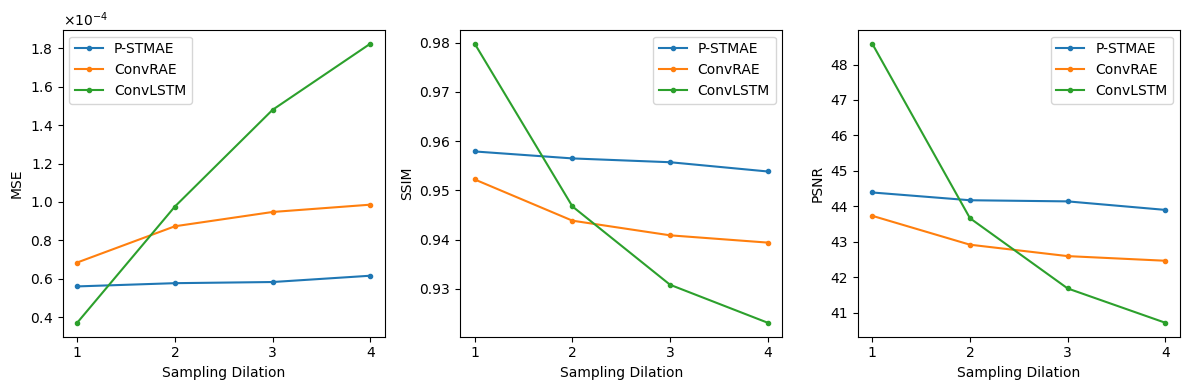

In [4]:
import os
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter


dilation_nums = [1, 2, 3, 4]

# Load TensorBoard log data
all_stats = {}
for model in ['timae', 'convrae', 'convlstm']:
    stats = {
        'test/mse': [],
        'test/ssim': [],
        'test/psnr': [],
    }
    # Load the data from multiple runs
    for dilation_num in dilation_nums:
        for ver_name in os.listdir(f"logs/{model}/dilation{dilation_num}/lightning_logs"):
            event_acc = event_accumulator.EventAccumulator(f"logs/{model}/dilation{dilation_num}/lightning_logs/{ver_name}")
            event_acc.Reload()
            for stat in stats.keys():
                stats[stat].append(event_acc.Scalars(stat)[-1].value)
    all_stats[model] = stats

model_name = {'timae': 'P-STMAE', 'convrae': 'ConvRAE', 'convlstm': 'ConvLSTM'}


fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3, height_ratios=[1])

ax, stat = fig.add_subplot(gs[0, 0]), 'test/mse'
for j, model in enumerate(all_stats.keys()):
    ax.plot(dilation_nums, all_stats[model][stat], label=model_name[model], marker='.')
ax.set_xticks(dilation_nums)
ax.set_xlabel('Sampling Dilation')
ax.set_ylabel('MSE')
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-4, 4))
ax.yaxis.set_major_formatter(formatter)
ax.legend()

ax, stat = fig.add_subplot(gs[0, 1]), 'test/ssim'
for j, model in enumerate(all_stats.keys()):
    ax.plot(dilation_nums, all_stats[model][stat], label=model_name[model], marker='.')
ax.set_xticks(dilation_nums)
ax.set_xlabel('Sampling Dilation')
ax.set_ylabel('SSIM')
ax.legend()

ax, stat = fig.add_subplot(gs[0, 2]), 'test/psnr'
for j, model in enumerate(all_stats.keys()):
    ax.plot(dilation_nums, all_stats[model][stat], label=model_name[model], marker='.')
ax.set_xticks(dilation_nums)
ax.set_xlabel('Sampling Dilation')
ax.set_ylabel('PSNR')
ax.legend()

plt.tight_layout()
# plt.savefig('sw_dilations.pdf', bbox_inches='tight', dpi=100)

# Diffusion Reaction

## Model Reconstruction

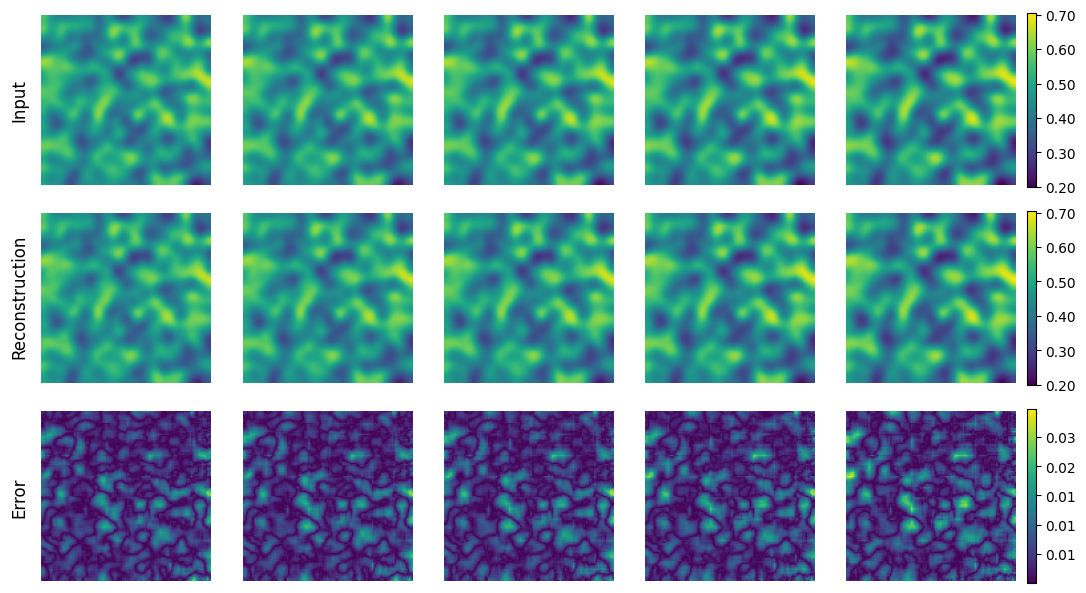

In [17]:
from data.dataset import DiffusionReactionDataset
from models.timae.pl_model import LitTiMAE
import matplotlib.pyplot as plt
import torch

dataset = DiffusionReactionDataset(dilation=5)
model = LitTiMAE.load_from_checkpoint('logs/timae/dilation5/lightning_logs/version_140165/checkpoints/epoch=79-step=60000.ckpt', map_location='cpu', dataset=dataset)

x, y, mask = dataset[10]
pred = model.model(x.unsqueeze(0), mask.unsqueeze(0))[0].squeeze(0).detach()

fig, axs = plt.subplots(3, 6, figsize=(11, 6), gridspec_kw={'width_ratios': [0, 1, 1, 1, 1, 1.25]})

axs[0, 0].text(x=0, y=0.4, s='Input', fontsize='large', rotation='vertical')
axs[1, 0].text(x=0, y=0.18, s='Reconstruction', fontsize='large', rotation='vertical')
axs[2, 0].text(x=0, y=0.4, s='Error', fontsize='large', rotation='vertical')

images = y[:, 0]
reconstructions = pred[10:, 0]
diffs = torch.abs(images - reconstructions)
i_vmin, i_vmax = torch.cat([images, reconstructions]).min(), torch.cat([images, reconstructions]).max()
for i in range(5):
    im1 = axs[0, i+1].imshow(images[i], vmin=i_vmin, vmax=i_vmax)
    im2 = axs[1, i+1].imshow(reconstructions[i], vmin=i_vmin, vmax=i_vmax)
    im3 = axs[2, i+1].imshow(diffs[i], vmin=diffs.min(), vmax=diffs.max())

fig.colorbar(im1, ax=axs[0, i+1], shrink=1, format='%.2f')
fig.colorbar(im2, ax=axs[1, i+1], shrink=1, format='%.2f')
fig.colorbar(im3, ax=axs[2, i+1], shrink=1, format='%.2f')

for i in range(3):
    for j in range(6):
        axs[i, j].axis('off')

plt.tight_layout()
# plt.savefig('dr_reconstruction.pdf', bbox_inches='tight', dpi=100)

## Model Comparison

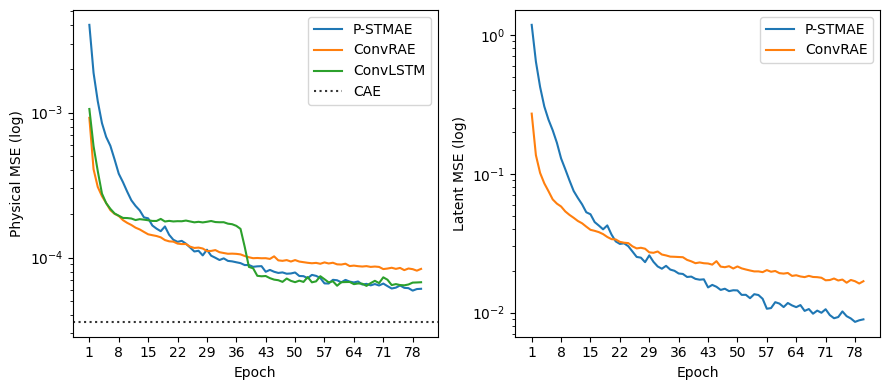

In [ ]:
import os
import numpy as np
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


# Load TensorBoard log data
all_stats = {}
for model in ['timae', 'convrae', 'convlstm']:
    stats = {
        'val/mse': {'steps': [], 'values': []},
        'val/latent_mse': {'steps': [], 'values': []},
    }
    # Load the data from multiple runs
    for ver_name in os.listdir(f"logs/{model}/dilation5/lightning_logs"):
        event_acc = event_accumulator.EventAccumulator(f"logs/{model}/dilation5/lightning_logs/{ver_name}")
        event_acc.Reload()
        for stat in stats.keys():
            if model == 'convlstm' and 'latent' in stat:
                continue
            steps = [event.step for event in event_acc.Scalars(stat)]
            values = [event.value for event in event_acc.Scalars(stat)]
            stats[stat]['steps'].append(steps)
            stats[stat]['values'].append(values)
    # convert to numpy arrays
    for stat in stats.keys():
        stats[stat]['steps'] = np.array(stats[stat]['steps'])
        stats[stat]['values'] = np.array(stats[stat]['values'])
    all_stats[model] = stats

event_acc = event_accumulator.EventAccumulator(f"logs/autoencoder/lightning_logs/diffusion_reaction_2")
event_acc.Reload()
ae_metric = lambda x: event_acc.Scalars(x)[-1].value

model_name = {'timae': 'P-STMAE', 'convrae': 'ConvRAE', 'convlstm': 'ConvLSTM'}


fig = plt.figure(figsize=(9, 4))
gs = gridspec.GridSpec(1, 2, height_ratios=[1])

ax, stat = fig.add_subplot(gs[0, 0]), 'val/mse'
max_steps = max([all_stats[model][stat]['steps'][0][-1] for model in all_stats.keys()])
for j, model in enumerate(all_stats.keys()):
    # Extract mean and std
    steps = all_stats[model][stat]['steps'][0]
    mean_values = np.mean(all_stats[model][stat]['values'], axis=0)
    std_values = np.std(all_stats[model][stat]['values'], axis=0)

    # Visualize the data
    ax.plot(steps, mean_values, label=model_name[model])
ax.axhline(ae_metric(stat), linestyle=':', color='black', alpha=0.8,  label='CAE')
ax.set_yscale('log')
ax.set_xticks(steps[::7], ((steps + 1) // 750)[::7])
ax.set_xlabel('Epoch')
ax.set_ylabel('Physical MSE (log)')
ax.legend()

ax, stat = fig.add_subplot(gs[0, 1]), 'val/latent_mse'
max_steps = max([all_stats[model][stat]['steps'][0][-1] for model in ['timae', 'convrae']])
for j, model in enumerate(['timae', 'convrae']):
    # Extract mean and std
    steps = all_stats[model][stat]['steps'][0]
    mean_values = np.mean(all_stats[model][stat]['values'], axis=0)
    std_values = np.std(all_stats[model][stat]['values'], axis=0)

    # Visualize the data
    ax.plot(steps, mean_values, label=model_name[model])
ax.set_xticks(steps[::7], ((steps + 1) // 750)[::7])
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Latent MSE (log)')
ax.legend()

plt.tight_layout()
# plt.savefig('dr_comparison.pdf', bbox_inches='tight', dpi=100)

# Compressible Navier-Stokes

## Model Reconstruction (Standard)

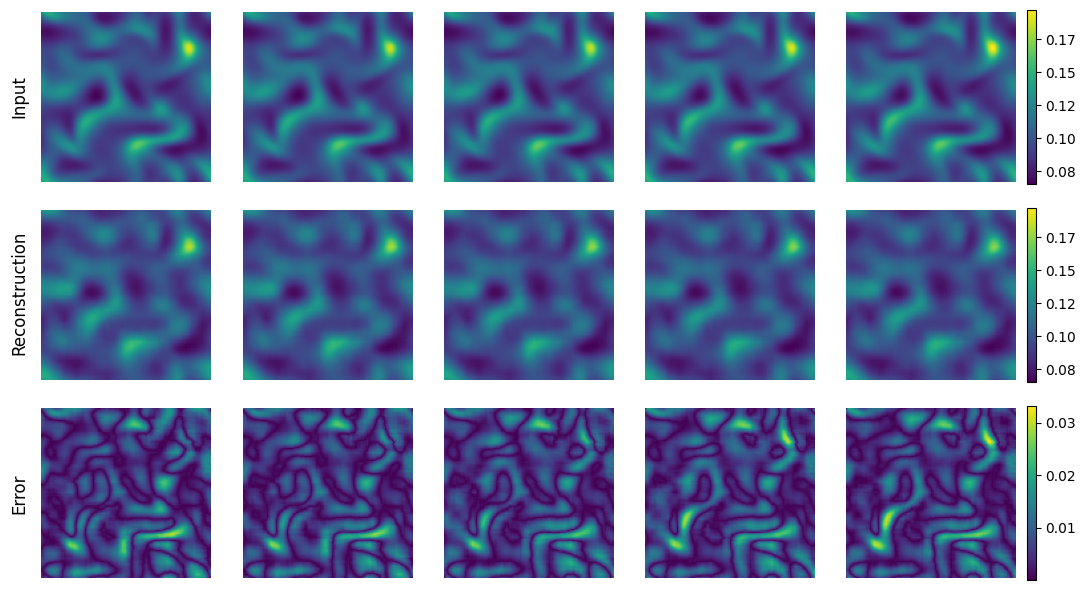

In [21]:
from data.dataset import CompressibleNavierStokesDataset
from models.timae.pl_model import LitTiMAE
import matplotlib.pyplot as plt
import torch

dataset = CompressibleNavierStokesDataset()
model = LitTiMAE.load_from_checkpoint('logs/timae/lightning_logs/version_124930/checkpoints/epoch=39-step=78760.ckpt', map_location='cpu', dataset=dataset)

x, y, mask = dataset[500]
pred = model.model(x.unsqueeze(0), mask.unsqueeze(0))[0].squeeze(0).detach()

fig, axs = plt.subplots(3, 6, figsize=(11, 6), gridspec_kw={'width_ratios': [0, 1, 1, 1, 1, 1.25]})

axs[0, 0].text(x=0, y=0.4, s='Input', fontsize='large', rotation='vertical')
axs[1, 0].text(x=0, y=0.18, s='Reconstruction', fontsize='large', rotation='vertical')
axs[2, 0].text(x=0, y=0.4, s='Error', fontsize='large', rotation='vertical')

images = y[:, 2]
reconstructions = pred[10:, 2]
diffs = torch.abs(images - reconstructions)
i_vmin, i_vmax = torch.cat([images, reconstructions]).min(), torch.cat([images, reconstructions]).max()
for i in range(5):
    im1 = axs[0, i+1].imshow(images[i], vmin=i_vmin, vmax=i_vmax)
    im2 = axs[1, i+1].imshow(reconstructions[i], vmin=i_vmin, vmax=i_vmax)
    im3 = axs[2, i+1].imshow(diffs[i], vmin=diffs.min(), vmax=diffs.max())

fig.colorbar(im1, ax=axs[0, i+1], shrink=1, format='%.2f')
fig.colorbar(im2, ax=axs[1, i+1], shrink=1, format='%.2f')
fig.colorbar(im3, ax=axs[2, i+1], shrink=1, format='%.2f')

for i in range(3):
    for j in range(6):
        axs[i, j].axis('off')

plt.tight_layout()
# plt.savefig('cns_std_reconstruction.pdf', bbox_inches='tight', dpi=100)

# NOAA Sea Surface Temperature

## Model Reconstruction

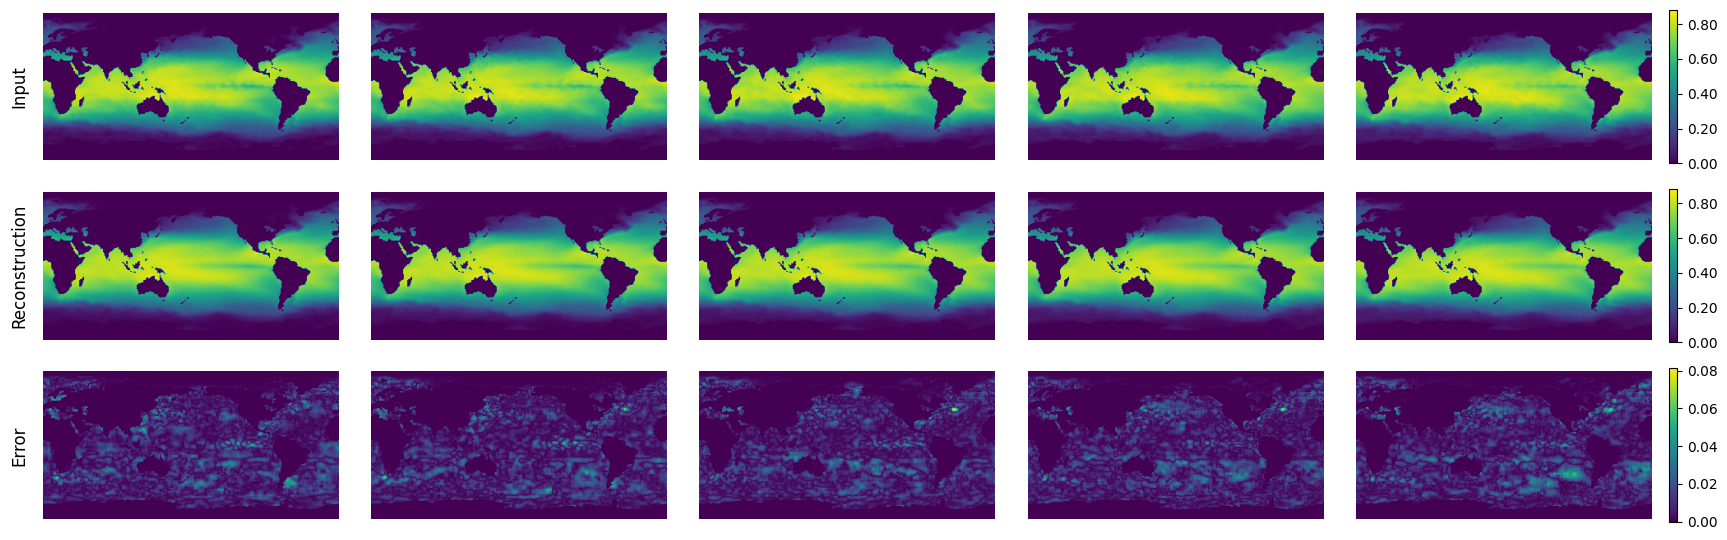

In [5]:
from data.dataset import NOAASeaSurfaceTemperatureDataset
from models.timae.pl_model import LitTiMAE
import matplotlib.pyplot as plt
import torch

dataset = NOAASeaSurfaceTemperatureDataset()
model = LitTiMAE.load_from_checkpoint('logs/timae/lightning_logs/heads8_depth8/checkpoints/epoch=69-step=3780.ckpt', map_location='cpu', dataset=dataset)

x, y, mask = dataset[100]
pred = model.model(x.unsqueeze(0), mask.unsqueeze(0))[0].squeeze(0).detach() * model.data_mask

fig, axs = plt.subplots(3, 6, figsize=(17.5, 5.5), gridspec_kw={'width_ratios': [0, 1, 1, 1, 1, 1.25]})

axs[0, 0].text(x=0, y=0.39, s='Input', fontsize='large', rotation='vertical')
axs[1, 0].text(x=0, y=0.12, s='Reconstruction', fontsize='large', rotation='vertical')
axs[2, 0].text(x=0, y=0.39, s='Error', fontsize='large', rotation='vertical')

images = y[:, 0]
reconstructions = pred[10:, 0]
diffs = torch.abs(images - reconstructions)
i_vmin, i_vmax = torch.cat([images, reconstructions]).min(), torch.cat([images, reconstructions]).max()
for i in range(5):
    im1 = axs[0, i+1].imshow(images[i], vmin=i_vmin, vmax=i_vmax)
    im2 = axs[1, i+1].imshow(reconstructions[i], vmin=i_vmin, vmax=i_vmax)
    im3 = axs[2, i+1].imshow(diffs[i], vmin=diffs.min(), vmax=diffs.max())

fig.colorbar(im1, ax=axs[0, i+1], shrink=1, format='%.2f')
fig.colorbar(im2, ax=axs[1, i+1], shrink=1, format='%.2f')
fig.colorbar(im3, ax=axs[2, i+1], shrink=1, format='%.2f')

for i in range(3):
    for j in range(6):
        axs[i, j].axis('off')

plt.tight_layout()
# plt.savefig('sst_reconstruction.pdf', bbox_inches='tight', dpi=100)

# Energy Conservation

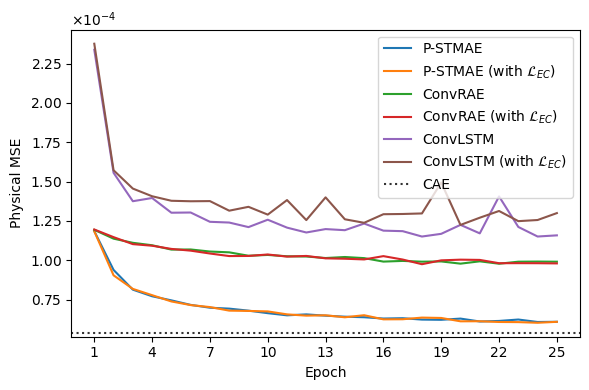

In [4]:
import numpy as np
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter

logdir = "/homes/yx723/b/logs/logs-sw_res128_2"
logdict = {
    'timae': ['dilation3_e0', 'dilation3_e0.1'],
    'convrae': ['dilation3_e0', 'dilation3_e0.1'],
    'convlstm': ['dilation3_e0_l2', 'dilation3_e0.1_l2'],
}


# Load TensorBoard log data
all_stats = {}
for model in ['timae', 'convrae', 'convlstm']:
    stats = {
        'val/mse': {'steps': [], 'values': []},
    }
    # Load the data from multiple runs
    for ver_name in logdict[model]:
        event_acc = event_accumulator.EventAccumulator(f"{logdir}/{model}/lightning_logs/{ver_name}")
        event_acc.Reload()
        for stat in stats.keys():
            steps = [event.step for event in event_acc.Scalars(stat)]
            values = [event.value for event in event_acc.Scalars(stat)]
            stats[stat]['steps'].append(steps)
            stats[stat]['values'].append(values)
    # convert to numpy arrays
    for stat in stats.keys():
        stats[stat]['steps'] = np.array(stats[stat]['steps'])
        stats[stat]['values'] = np.array(stats[stat]['values'])
    all_stats[model] = stats

event_acc = event_accumulator.EventAccumulator(f"{logdir}/autoencoder/lightning_logs/version_2")
event_acc.Reload()
ae_metric = lambda x: event_acc.Scalars(x)[-1].value

model_name = {'timae': 'P-STMAE', 'convrae': 'ConvRAE', 'convlstm': 'ConvLSTM'}


fig = plt.figure(figsize=(6, 4))
gs = gridspec.GridSpec(1, 1, height_ratios=[1])

ax, stat = fig.add_subplot(gs[0, 0]), 'val/mse'
steps = all_stats['convrae'][stat]['steps'][0]
for j, model in enumerate(all_stats.keys()):
    ax.plot(steps, all_stats[model][stat]['values'][0][:len(steps)], label=model_name[model])
    ax.plot(steps, all_stats[model][stat]['values'][1][:len(steps)], label=model_name[model]+' (with $\\mathcal{L}_{EC}$)')
ax.axhline(ae_metric(stat), linestyle=':', color='black', alpha=0.8,  label='CAE')
ax.set_xticks(steps[::3], ((steps + 1) // 2667)[::3])
ax.set_xlabel('Epoch')
ax.set_ylabel('Physical MSE')
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-4, 4))
ax.yaxis.set_major_formatter(formatter)
ax.legend(loc='upper right')

plt.tight_layout()
# plt.savefig('pc_energy.pdf', bbox_inches='tight', dpi=100)